# Day 1-2 measurements and sample discussion

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import mplhep as hep

from utils import angle_data
from utils.style import make_style
make_style()

from utils.angle_data import AngleData, SingleRun, get_data
# from utils import fresnel

import glob 

Loading datasets

Angular distribution for normal incidence over photodiode


In [2]:
normal_dist_files = sorted(glob.glob('../data/normal_dist/**'))
nd_adl = get_data(normal_dist_files, 23)

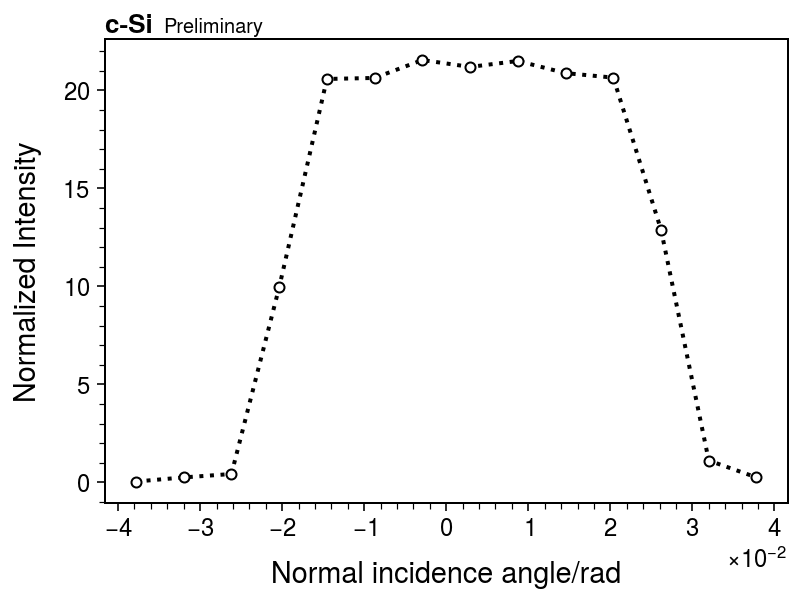

In [3]:
nd_s1 = SingleRun(nd_adl)

center = nd_s1.angles.mean()
nd_s1.angles -= center

from scipy import integrate
integral = integrate.simpson(nd_s1.reflectance, dx=np.abs(nd_s1.angles[1]-nd_s1.angles[0]))
nd_s1.reflectance = nd_s1.reflectance/integral

nd_s1.plot(marker='o:')
hep.label.exp_text('c-Si ', 'Preliminary')
plt.ylabel('Normalized Intensity')
plt.savefig('../figures/angle_spread.pdf', bbox_inches='tight')

In [4]:
Si_s_adl = get_data(sorted(glob.glob('../data/dataSi_0/**.lvm')), 23)
Si_p_adl = get_data(sorted(glob.glob('../data/dataSi_1/**.lvm')), 23)

p_Si = SingleRun(Si_p_adl, Si_p_adl[-1])
s_Si = SingleRun(Si_s_adl, Si_s_adl[-1])

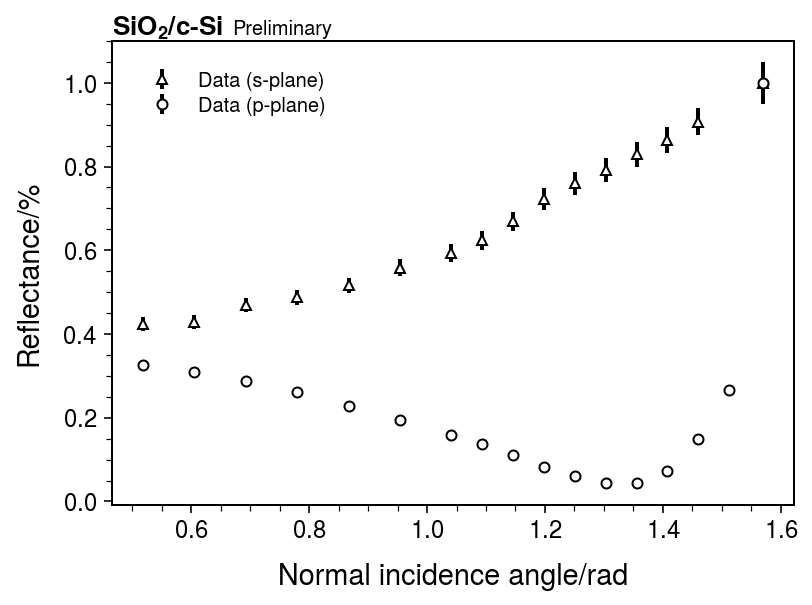

In [5]:
s_Si.plot(color='k', marker='^')
p_Si.plot(color='k', marker='o')
hep.label.exp_text('SiO$\mathbf{_2}$/c-Si ', 'Preliminary')
plt.legend()

In [6]:
def r_12_p(theta, n1, n2):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    return (
        (n2 * np.cos(theta) - n1 * cos_theta2) / (n1 * cos_theta2 + n2 * np.cos(theta))
    )

def r_12_s(theta, n1, n2):
    '''Compute r_s fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    return (
        (n1 * np.cos(theta) - n2 * cos_theta2) / (n1 * np.cos(theta) + n2 * cos_theta2)
    )

def r_23_p(theta, n1, n2, n3):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    cos_theta3 = np.sqrt(1 - ((n1/n3) * np.sin(theta))**2)
    return (
        (n3 * cos_theta2 - n2 * cos_theta3) / (n3 * cos_theta2 + n2 * cos_theta3)
    )

def r_23_s(theta, n1, n2, n3):
    '''Compute r_s fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    
    cos_theta2 = np.sqrt(1 - ((n1/n2) * np.sin(theta))**2)
    cos_theta3 = np.sqrt(1 - ((n1/n3) * np.sin(theta))**2)
    return (
        (n2 * cos_theta2 - n3 * cos_theta3) / (n2 * cos_theta2 + n3 * cos_theta3)
    )
    
def phi(theta, ni, nt, d): 
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return 2 * np.pi * d * nt/ 532 * cos_transmitted
    
def construct_three_layer_r(r_al: callable, r_ls: callable, theta, n1, n2, n3, d):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    `n3`: complex refractive indices for material 3 (n = n + k*1j)
    `d` : inner layer width
    '''
    
    return (
        (r_al(theta, n1, n2) + r_ls(theta, n1, n2, n3) * np.exp(2j * phi(theta, n1, n2, d)))/
        (1 + r_al(theta, n1, n2) * r_ls(theta, n1, n2, n3) * np.exp(2j * phi(theta, n1, n2, d)))
    )


def Si_Rs(theta, n1, n2, n3, d):
    rs_tot = construct_three_layer_r(r_12_s, r_23_s, theta, n1, n2, n3, d)
    return np.abs( rs_tot * np.conj(rs_tot) )

def Si_Rp(theta, n1, n2, n3, d):
    rp_tot = construct_three_layer_r(r_12_p, r_23_p, theta, n1, n2, n3, d)
    return np.abs( rp_tot * np.conj(rp_tot) )


Appunti da ricordare: le formule per il multilayer sono da correggere perché $r_s$ e $r_p$ dipendono dagli angoli di incisione sull'interfaccia considerata e non sulla prima interfaccia

In [7]:
from iminuit import Minuit, minuit

def fcn_Si(n1, k1, n2, k2, n3, k3, d):
    cn1, cn2, cn3 = n1+k1*1j, n2+k2*1j, n3+k3*1j
    fcn = 0.0
    for x, y, std in zip(s_Si.angles, s_Si.reflectance, s_Si.reflectance_std):
        fcn += ((y - Si_Rs(x, cn1, cn2, cn3, d)) / std)**2

    for x, y, std in zip(p_Si.angles, p_Si.reflectance, p_Si.reflectance_std):
        fcn += ((y - Si_Rp(x, cn1, cn2, cn3, d)) / std)**2
    return fcn

n_Air  = 1.00027821
n_SiO2 = 1.4607
n_Si = 4.1360
k_Si = 0.010205

m_Si = Minuit(fcn_Si, n1=1, k1=0.0, n2=1.45, k2=0.0, n3=4.1, k3=0.01, d=2.5)

# m_Si.limits['n1'] = (0.75, 1.15)
# m_Si.limits['n2'] = (0.5, 1.55)
# m_Si.limits['k2'] = (0., 1.)
m_Si.limits['n3'] = (2.25, 4.45)
m_Si.limits['k3'] = (0.001, 0.01)
m_Si.limits['d']  = (1., 4.)

m_Si.fixed['k1'] = True

m_Si.migrad()
m_Si.hesse()
m_Si.migrad()
m_Si.hesse()
m_Si.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.324e+04                  │             Nfcn = 3038              │
│ EDM = 0.0164 (Goal: 0.0002)      │            time = 4.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n1   │  1.1106   │  0.0031   │            │            │         │         │       │
│ 1 │ k1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ n2   │  0.0723   │  0.0010   │            │            │         │         │       │
│ 3 │ k2   │  -0.424   │   0.004   │            │            │         │         │       │
│ 4 │ n3   │   4.436   │   0.013   │            │            │  2.25   │  4.45   │       │
│ 5 │ k3   │  0.0010   │  0.0018   │            │            │  0.001  │  0.01   │       │
│ 6 │ d    │   1.003   │   0.009   │            │            │    1    │    4    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │        n1        k1        n2        k2        n3        k3         d │
├────┼───────────────────────────────────────────────────────────────────────┤
│ n1 │   9.5e-06         0  2.93e-06 -1.36e-05  3.89e-05 -9.06e-13  2.78e-05 │
│ k1 │         0         0         0         0         0         0         0 │
│ n2 │  2.93e-06         0     1e-06 -4.14e-06  1.16e-05 -4.72e-12  8.31e-06 │
│ k2 │ -1.36e-05         0 -4.14e-06  1.98e-05 -5.67e-05 -3.56e-12 -4.05e-05 │
│ n3 │  3.89e-05         0  1.16e-05 -5.67e-05  0.000163  2.15e-11  0.000116 │
│ k3 │ -9.06e-13         0 -4.72e-12 -3.56e-12  2.15e-11  4.64e-12  1.22e-11 │
│  d │  2.78e-05         0  8.31e-06 -4.05e-05  0.000116  1.22e-11  8.32e-05 │
└────┴───────────────────────────────────────────────────────────────────────┘

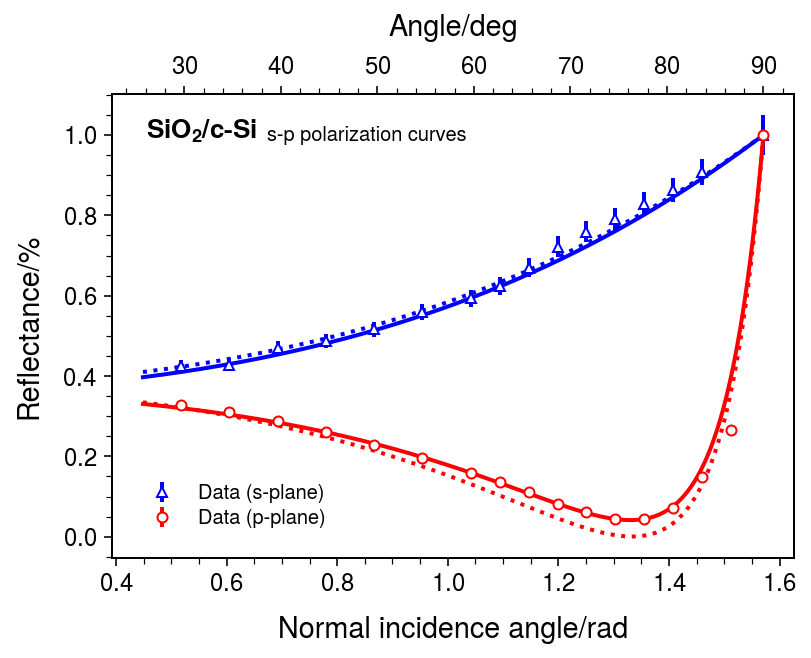

In [8]:
s_Si.plot(color='b', marker='^')
p_Si.plot(color='r', marker='o')

angles = np.linspace(np.pi/7, np.pi/2, 500)
n1,k1,n2,k2,n3,k3,d = m_Si.values

# FIT
plt.plot(angles, Si_Rs(angles, n1+k1*1j, n2+k2*1j, n3+k3*1j, d), color='b')
plt.plot(angles, Si_Rp(angles, n1+k1*1j, n2+k2*1j, n3+k3*1j, d), color='r')

# THEORY
plt.plot(angles, Si_Rs(angles, n_Air, n_SiO2, n_Si+k_Si*1j, 2), color='b', ls=':')
plt.plot(angles, Si_Rp(angles, n_Air, n_SiO2, n_Si+k_Si*1j, 2), color='r', ls=':')


hep.label.exp_text('SiO$\mathbf{_2}$/c-Si ', 's-p polarization curves',loc=1)
ax = plt.gca().secondary_xaxis('top', functions=(np.rad2deg, np.deg2rad))
ax.set_xlabel('Angle/deg')
plt.legend(loc=3)
plt.savefig('../figures/c_Si_Rs_Rp.pdf', bbox_inches='tight')

Analyzing Au data

In [9]:
Au_s_adl = get_data(sorted(glob.glob('../data/dataAu_0/**.lvm')), 23)
Au_p_adl = get_data(sorted(glob.glob('../data/dataAu_1/**.lvm')), 23)

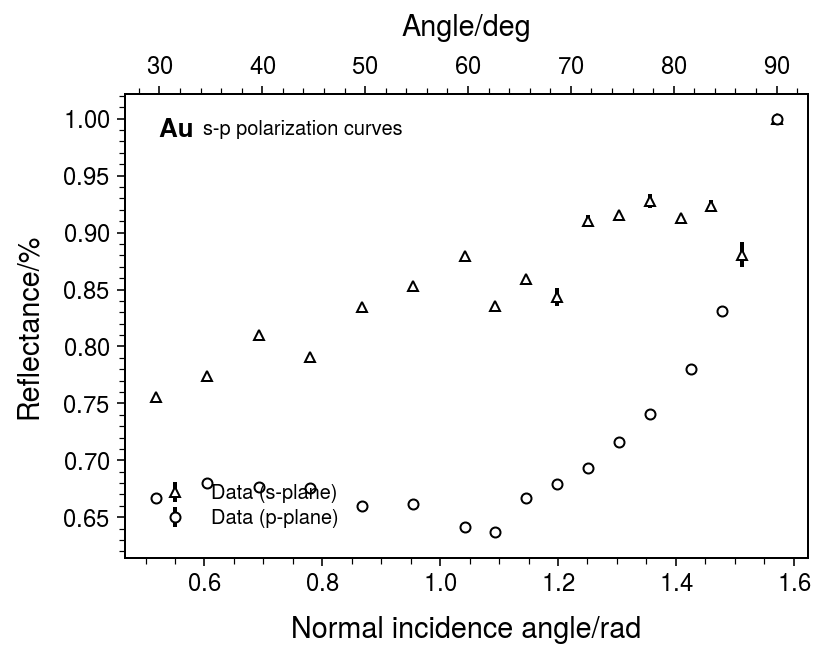

In [10]:
s_Au = SingleRun(Au_s_adl, Au_s_adl[-1])
p_Au = SingleRun(Au_p_adl, Au_p_adl[-1])
s_Au.plot(marker='^')
p_Au.plot()

ax = plt.gca().secondary_xaxis('top', functions=(np.rad2deg, np.deg2rad))
ax.set_xlabel('Angle/deg')

hep.label.exp_text('Au ', 's-p polarization curves', loc=1)
plt.legend(loc=3)

In [11]:
def r_p(theta, ni, nt):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return (
        (nt * np.cos(theta) - ni * cos_transmitted) / (ni * cos_transmitted + nt * np.cos(theta))
    )

def r_s(theta, ni, nt):
    '''Compute r_s fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return (
        (ni * np.cos(theta) - nt * cos_transmitted) / (ni * np.cos(theta) + nt * cos_transmitted)
    )

def Au_Rs(theta, n1, n2):
    rs = r_s(theta, n1, n2)
    return np.abs( rs * np.conj(rs) )

def Au_Rp(theta, n1, n2):
    rp = r_p(theta, n1, n2)
    return np.abs( rp * np.conj(rp) )

In [12]:
def fcn_Au(n1, k1, n2, k2):
    fcn = 0.0
    for x, y, std in zip(s_Au.angles, s_Au.reflectance, s_Au.reflectance_std):
        fcn += ((y - Au_Rs(x, n1+k1*1j, n2+k2*1j)) / std)**2
    for x, y, std in zip(p_Au.angles, p_Au.reflectance, p_Au.reflectance_std):
        fcn += ((y - Au_Rp(x, n1+k1*1j, n2+k2*1j)) / std)**2
    return fcn

n_Air  = 1.00027821
n_Au   = 0.54463
k_Au   = 2.1406

m_Au = Minuit(fcn_Au, n1=n_Air, k1=0, n2=n_Au, k2=k_Au)
m_Au.fixed['k1']=True
m_Au.migrad()
m_Au.hesse()
m_Au.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2302                       │              Nfcn = 152              │
│ EDM = 7.44e-12 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n1   │   1.25    │   0.17    │            │            │         │         │       │
│ 1 │ k1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ n2   │   0.43    │   0.06    │            │            │         │         │       │
│ 3 │ k2   │   2.27    │   0.32    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────┐
│    │      n1      k1      n2      k2 │
├────┼─────────────────────────────────┤
│ n1 │  0.0306       0  0.0105  0.0557 │
│ k1 │       0       0       0       0 │
│ n2 │  0.0105       0 0.00363  0.0192 │
│ k2 │  0.0557       0  0.0192   0.101 │
└────┴─────────────────────────────────┘

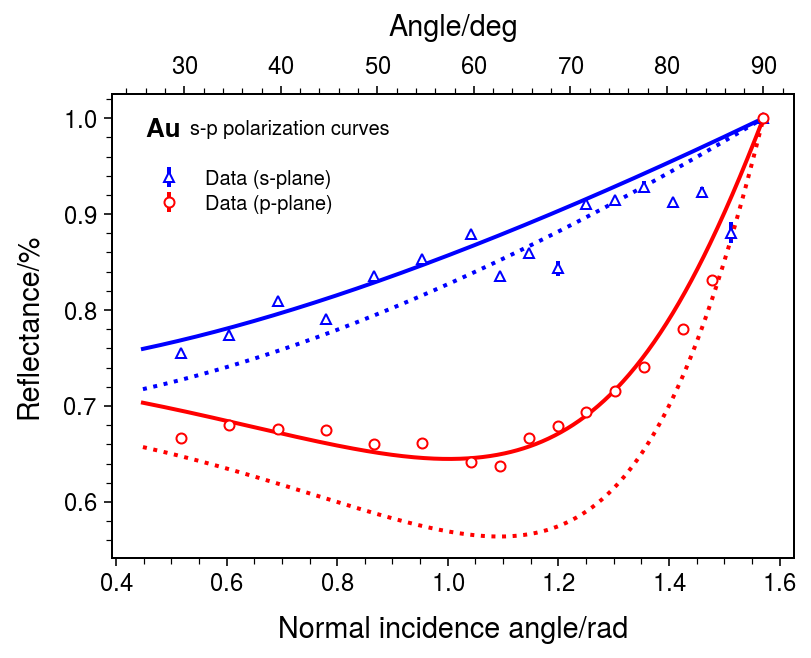

In [15]:
s_Au.plot(marker='^', color='b')
p_Au.plot(color='r')

hep.label.exp_text('Au ', 's-p polarization curves', loc=1)

n1,k1,n2,k2 = m_Au.values
plt.plot(angles, Au_Rs(angles, n1+k1*1j, n2+k2*1j), color='b')
plt.plot(angles, Au_Rp(angles, n1+k1*1j, n2+k2*1j), color='r')

plt.plot(angles, Au_Rs(angles, n_Air, n_Au+k_Au*1j), color='b', ls=':')
plt.plot(angles, Au_Rp(angles, n_Air, n_Au+k_Au*1j), color='r', ls=':')

ax = plt.gca().secondary_xaxis('top', functions=(np.rad2deg, np.deg2rad))
ax.set_xlabel('Angle/deg')

plt.legend(loc=(0.025, 0.7))
plt.savefig('../figures/Au_Rs_Rp.pdf', bbox_inches='tight')